In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
import random
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import numpy as np
import seaborn as sns
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

In [3]:
train_path ='/kaggle/input/titanic-machine-learning-from-disaster/train.csv'
test_path ='/kaggle/input/titanic-machine-learning-from-disaster/test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def preprocessing_dataframe(df, test=False):
    df_clean = df
    df_clean['Pclass'] = df_clean['Pclass'].astype('int32')
    df_clean['Age'] = df_clean['Age'].astype('float32')
    df_clean['SibSp'] = df_clean['SibSp'].astype('int32')
    df_clean['Parch'] = df_clean['Parch'].astype('int32')
    df_clean['Fare'] = df_clean['Fare'].astype('float32')
    if not test:
        df_clean['Survived'] = df_clean['Survived'].astype('int32')
    return df_clean

df_train = preprocessing_dataframe(df_train, test=False)
df_test = preprocessing_dataframe(df_test, test=True)

In [5]:
for col in df_train.columns:
    num_nans = np.sum(df_train[col].isna())
    if num_nans>0:
        print(col,num_nans)

Age 177
Cabin 687
Embarked 2


In [6]:
for col in df_test.columns:
    num_nans = np.sum(df_test[col].isna())
    if num_nans>0:
        print(col,num_nans)

Age 86
Fare 1
Cabin 327


In [7]:
combined = [ df_train, df_test]

# Pclass

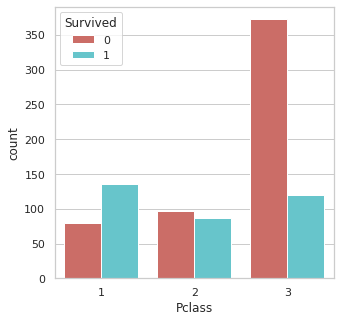

In [8]:
plt.figure(figsize=(5,5))
sns.countplot(x='Pclass', data=df_train, palette='hls', hue='Survived')
plt.show()

# SisSp and Parch

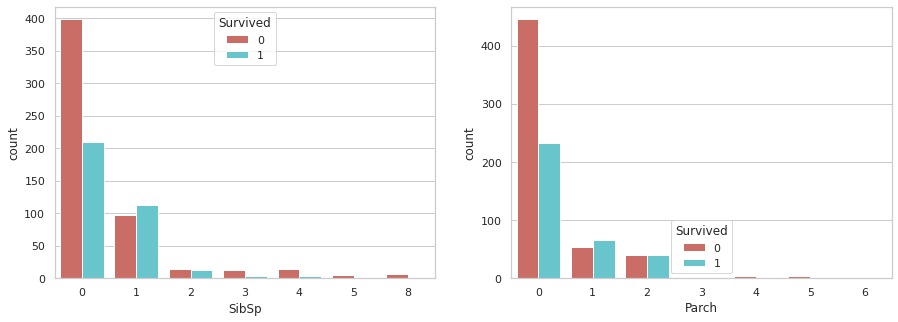

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='SibSp', data=df_train, palette='hls', hue='Survived')
plt.subplot(122)
sns.countplot(x='Parch', data=df_train, palette='hls', hue='Survived')
plt.show()

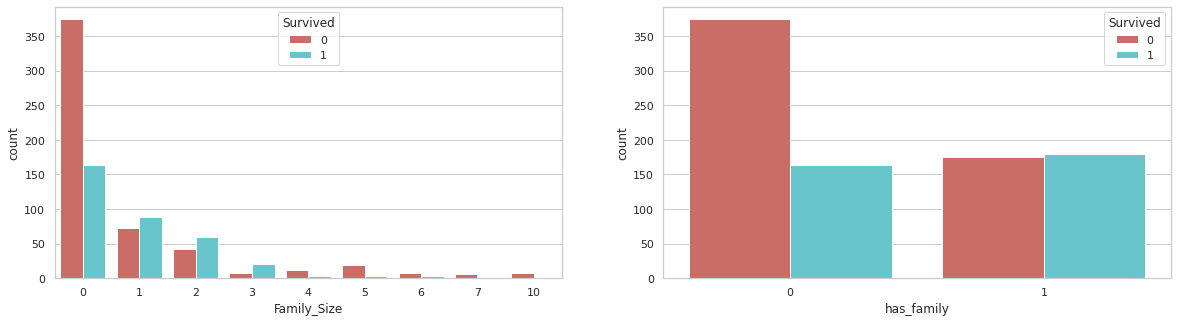

In [10]:
for d in combined:
    d['Family_Size'] = d['SibSp'] + d['Parch']
    d['has_family'] = (d['Family_Size']>0).astype('int32')
    
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(x='Family_Size', data=df_train, palette='hls', hue='Survived')
plt.subplot(122)
sns.countplot(x='has_family', data=df_train, palette='hls', hue='Survived')
plt.show()

# Age and Fare

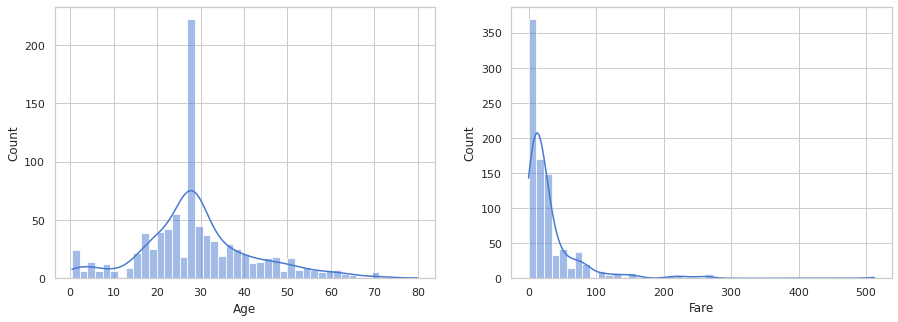

In [11]:
for d in combined:
    d['is_Age'] = 1-d['Age'].isna().astype('int32')
    d['is_Fare'] = 1-d['Fare'].isna().astype('int32')
    
for d in combined:
    d['Age'].fillna(d['Age'].median(), inplace=True)
    d['Fare'].fillna(d['Fare'].median(), inplace=True)
    
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.histplot(df_train["Age"], bins=45, kde=True)
plt.subplot(122)
sns.histplot(df_train["Fare"], bins=45, kde=True)
plt.show()

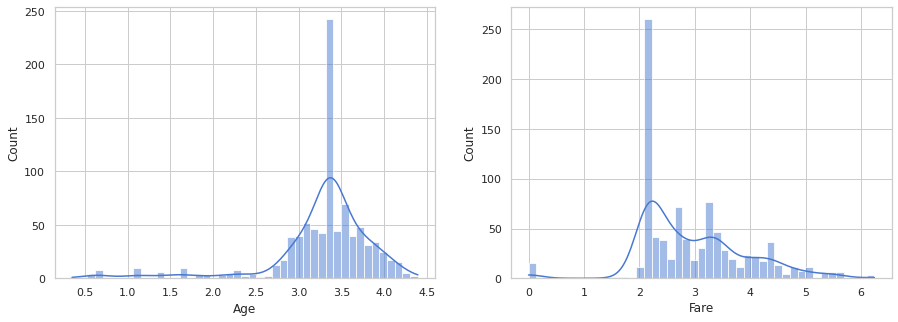

In [12]:
for d in combined:
    d["Age"] = np.log1p(d["Age"])
    d["Fare"] = np.log1p(d["Fare"])

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.histplot(df_train["Age"], bins=45, kde=True)
plt.subplot(122)
sns.histplot(df_train["Fare"], bins=45, kde=True)
plt.show()

# Sex

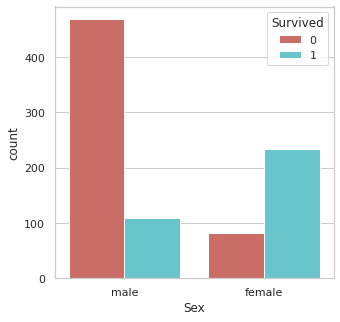

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(x='Sex', data=df_train, palette='hls', hue='Survived')
plt.show()

# Embarked

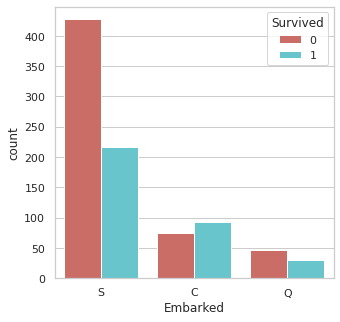

In [14]:
for d in combined:
    d.fillna(d['Embarked'].mode(), inplace=True)
    
plt.figure(figsize=(5,5))
sns.countplot(x='Embarked', data=df_train, palette='hls', hue='Survived')
plt.show()

# Name

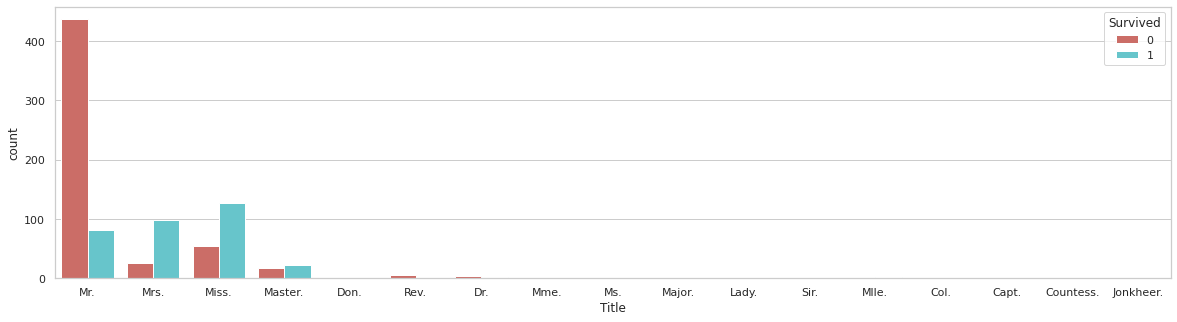

In [15]:
for d in combined:
    d['Title'] = d.Name.apply(lambda x: [t for t in x.split() if '.' in t ][0])

plt.figure(figsize=(20,5))
sns.countplot(x='Title', data=df_train, palette='hls', hue='Survived')
plt.show()

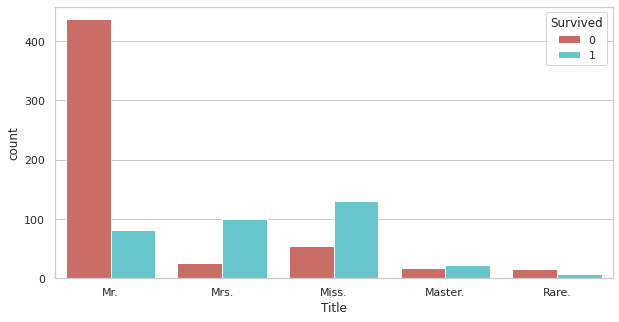

In [16]:
def replace_list(x, listwords, new_word):
    for s in listwords:
        x = x.replace(s, new_word)
    return x

for d in combined:
    d['Title'] = d['Title'].apply(lambda x: replace_list(x, \
    ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], \
    'Rare'))
    d['Title'] = d['Title'].apply(lambda x: replace_list(x, ['Mlle'], 'Miss'))
    d['Title'] = d['Title'].apply(lambda x: replace_list(x, ['Ms'], 'Miss'))
    d['Title'] = d['Title'].apply(lambda x: replace_list(x, ['Mme'], 'Mrs'))
    
plt.figure(figsize=(10,5))
sns.countplot(x='Title', data=df_train, palette='hls', hue='Survived')
plt.show()

# Cabin

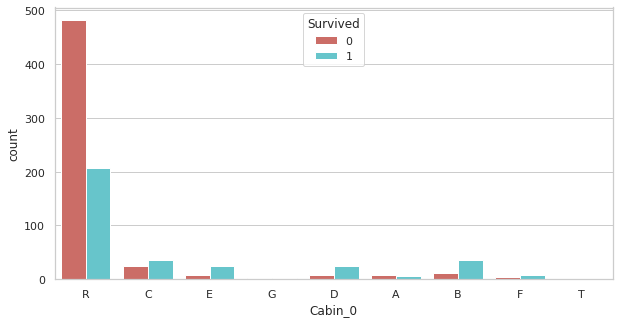

In [17]:
for d in combined:
    d['Cabin'].fillna('Regular', inplace=True)
    d["Cabin_0"] = d["Cabin"].apply(lambda x:x[0])
    
plt.figure(figsize=(10,5))
sns.countplot(x='Cabin_0', data=df_train, palette='hls', hue='Survived')
plt.show()    

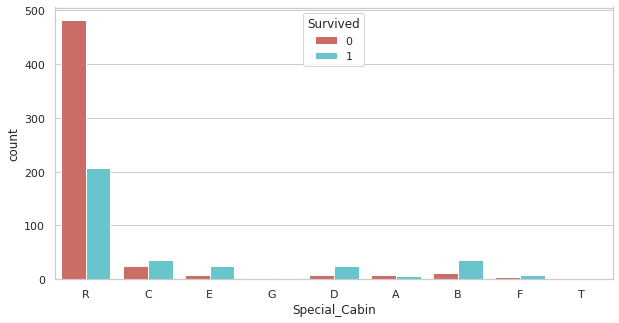

In [18]:
for d in combined:
    d["Special_Cabin"] = d.Cabin_0#.map( {"A":1,"B":1,"C":1,"D":1,"E":1,"F":1,"G":1,"T":1,"R":0} )
    
plt.figure(figsize=(10,5))
sns.countplot(x='Special_Cabin', data=df_train, palette='hls', hue='Survived')
plt.show()

In [19]:
def preprocessing_dataframe(df, test=False):
    df_clean = df
    df_clean['Pclass'] = df_clean['Pclass'].astype('int32')
    df_clean['Age'] = df_clean['Age'].astype('float32')
    df_clean['SibSp'] = df_clean['SibSp'].astype('int32')
    df_clean['Parch'] = df_clean['Parch'].astype('int32')
    df_clean['Fare'] = df_clean['Fare'].astype('float32')
    if not test:
        df_clean['Survived'] = df_clean['Survived'].astype('int32')
    return df_clean

df_train = preprocessing_dataframe(df_train)
df_test = preprocessing_dataframe(df_test, test=True)

In [20]:
x_features_columns = ['Pclass','Sex','Age','is_Age','has_family','Fare','is_Fare','Embarked','Special_Cabin','Title']#,'Ticket_type']
from collections import Counter
dfs=[]
for g,df in df_train[x_features_columns].groupby(x_features_columns):
    sv_values =  df_train.iloc[df.index]['Survived'].values
    if len(df)>1:
        df1 = df.iloc[0:1]
        df1['Survived']=Counter(df_train.iloc[df.index]['Survived'].values).most_common()[0][0]
        dfs.append(df1)
    else:
        df1 = df.iloc[0:1]
        df1['Survived'] = df_train.iloc[df.index[0]]['Survived']
        dfs.append(df1)
dfs=pd.concat(dfs,axis=0)
print(len(df_train),'->',len(dfs))
df_train=dfs

891 -> 776


In [21]:
feat2transform={
    'Pclass':OneHotEncoder(), 
    'Sex':LabelEncoder(), 
    'Age':MinMaxScaler(), 
    'is_Age':LabelEncoder(), 
    'SibSp':MinMaxScaler(),
    'Parch':MinMaxScaler(),
    'Family_Size':MinMaxScaler(),
    'has_family':LabelEncoder(), 
    'Fare':MinMaxScaler(),  
    'is_Fare':LabelEncoder(), 
    'Embarked':OneHotEncoder(),
    'Special_Cabin':OneHotEncoder(),
    'Title':OneHotEncoder(),
    'Ticket_type':OneHotEncoder(),
}

def fit_transformations(df_clean):
    for col in x_features_columns:
        t = feat2transform[col]
        t.fit(df_clean[col].values.reshape([-1,1]))

def preprocessing_data(df_clean, test=False):
    
    data = []
    for col in x_features_columns:
        t = feat2transform[col]
        d = t.transform(df_clean[col].values.reshape([-1,1]))
        if type(t) is OneHotEncoder:
            d = d.toarray()
        if type(t) is LabelEncoder:
            d = d.reshape([-1,1])
        data.append(d)
    
    data = np.concatenate(data,axis=1)
    
    if test:
        return data
    
    target = df_clean['Survived'].values.reshape([-1,1])
    
    return data,target

fit_transformations(pd.concat([df_train, df_test]))
data,target = preprocessing_data(df_train)
test_data = preprocessing_data(df_test, test=True)

In [22]:
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.decomposition import PCA
import sys
from sklearn.manifold import TSNE

# Aditional Features

In [23]:
X = np.concatenate([data, test_data], axis=0)
print(X.shape)
pca = PCA(n_components=10)
pca.fit(X)

data_pca= pca.transform(data)
test_pca= pca.transform(test_data)

data_pca=data_pca#/np.linalg.norm(Y)
test_pca=test_pca#/np.linalg.norm(Y)

data_and_pca=np.concatenate([data, data_pca],axis=1)
test_and_pca=np.concatenate([test_data, test_pca],axis=1)
print(data_and_pca.shape)

(1194, 27)
(776, 37)


# Model

In [24]:
from sklearn.model_selection import train_test_split

param_grid = {
    'n_estimators': [1000, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[5,7,9]
}

grid = GridSearchCV(estimator=RandomForestClassifier(), 
                    param_grid=param_grid,
                    cv=5,
                    verbose=2,
                    n_jobs=-1)
grid.fit(data_and_pca, target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1000, 2000]},
             verbose=2)

In [25]:
prediction = grid.best_estimator_.predict(test_and_pca)
df_test['Survived']=prediction
res = df_test[['PassengerId','Survived']]
res.to_csv('output.csv', index=False)